# Data Engineer Test
## Vanessa Movilla 

## Exploración de la Data

In [ ]:
import datetime
from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.linear_model import LinearRegression
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import numpy as np


Conexión con BigQuery

In [ ]:
credentials = service_account.Credentials.from_service_account_file(
'credentials.json')
project_id ='seleccion-analyticlab'
client = bigquery.Client(credentials= credentials,project=project_id)

A continuación se muestran algunos ejemplos de los querys realizados para explorar los datos de la tabla 'Homicidios_2018'. No se encontraron problemas significativos con la calidad de los datos, sin embargo se listan algunos hallazgos a tener en cuenta. 
- En una de las filas solo hay información en la columna 'Cantidad' por lo que es eliminada
- El nombre de la variable Clase_de_empleado no describe correctamente los valores que toma, un ejemplo de esto es el hecho de que 'Afrodescendiente' y 'Etnia Indigena' no son una clase de empleado.Sin embargo, esto no afecta el analisis que se realizará por lo que es simplemente una observación.
- Hay algunas columnas que no nos brindan mucha información, como lo son la de Cantidad y Profesión, por lo que se omitiran al momento de hacer el analisis.
- El formato en el que se encuentra la primera columna dificulta su tratamiento( incluye texto correspondiente a hora y las letras AM), sin embargo se puede pasar a fecha tomando solo los primeros 8 caracteres del string. 

### Querys


In [ ]:
query = """
SELECT  * 
FROM `seleccion-analyticlab.HomicidiosColombia.Homicidios_2018` 
LIMIT 5
"""
query_job = client.query(query)
results_head = query_job.result().to_dataframe()
results_head

,Fecha,Departamento,Municipio,Dia,Hora,Barrio,Zona,Clase_de_sitio,Arma_empleada,Movil_agresor,Movil_victima,Edad,Sexo,Estado_civil,Pais_de_nacimiento,Clase_de_empleado,Profesion,Escolaridad,Codigo_DANE,Cantidad
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,12667
1,11/04/2018 12:00:00 AM,META,SAN MARTÍN,Miércoles,11:24:00,MANANTIAL,URBANA,TIENDA,ARMA DE FUEGO,PASAJERO MOTOCICLETA,A PIE,33,MASCULINO,UNION LIBRE,COLOMBIA,EMPLEADO PARTICULAR,-,SECUNDARIA,50689000,1
2,11/07/2018 12:00:00 AM,META,SAN MARTÍN,Miércoles,20:30:00,PEDRO DAZA,URBANA,CASAS DE HABITACION,ARMA DE FUEGO,A PIE,A PIE,48,MASCULINO,UNION LIBRE,COLOMBIA,INDEPENDIENTE,-,PRIMARIA,50689000,1
3,03/01/2018 12:00:00 AM,META,VILLAVICENCIO (CT),Miércoles,13:10:00,MORICHAL,URBANA,CASAS DE HABITACION,ARMA DE FUEGO,A PIE,A PIE,27,MASCULINO,UNION LIBRE,COLOMBIA,INDEPENDIENTE,-,SECUNDARIA,50001000,1
4,04/01/2018 12:00:00 AM,META,VILLAVICENCIO (CT),Jueves,20:57:00,BOSQUES DE ABAJAM*,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,PASAJERO MOTOCICLETA,A PIE,29,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,-,PRIMARIA,50001000,1


In [ ]:
query = """
SELECT  Distinct Departamento  
FROM `seleccion-analyticlab.HomicidiosColombia.Homicidios_2018` 
"""
query_job = client.query(query)
results_Departamento = query_job.result().to_dataframe()
print(results_Departamento[:5])

  Departamento
0         None
1         META
2        CAUCA
3        CESAR
4        HUILA


In [ ]:
query = """
SELECT  Hora
        ,Count(*) AS Count  
FROM `seleccion-analyticlab.HomicidiosColombia.Homicidios_2018` 
GROUP BY Hora
"""
query_job = client.query(query)
results_Hora = query_job.result().to_dataframe()
print(results_Hora)

         Hora  Count
0        None      1
1    11:24:00      2
2    20:30:00     80
3    13:10:00     12
4    20:57:00      3
..        ...    ...
830  18:41:00      1
831   1:08:00      1
832  10:26:00      1
833  23:08:00      1
834   9:55:00      1

[835 rows x 2 columns]


In [ ]:
query = """
SELECT  Profesion
        ,Count(*) AS Count  
FROM `seleccion-analyticlab.HomicidiosColombia.Homicidios_2018` 
GROUP BY Profesion
"""
query_job = client.query(query)
results_Profesion = query_job.result().to_dataframe()
print(results_Profesion.sort_values('Count',ascending=False)[:8])

                                     Profesion  Count
1                                            -   4838
3                                 NO REPORTADA     47
7   TECNICO PROFESIONAL EN SERVICIO DE POLICIA     24
4                                     POLICIAS     13
5                                      DERECHO      4
12                                  LICENCIADO      4
13                                   INGENIERO      4
15                       INGENIERÍA INDUSTRIAL      2


In [ ]:
query = """
SELECT  Cantidad
        ,Count(*) AS Count  
FROM `seleccion-analyticlab.HomicidiosColombia.Homicidios_2018` 
GROUP BY Cantidad
"""
query_job = client.query(query)
results_Cantidad = query_job.result().to_dataframe()
print(results_Cantidad)

  Cantidad  Count
0    12667      1
1        1   4957
2        3      1
3        2      7


## Data insights

###What were the top municipalities with highest quantity of murders by month?

In [ ]:
query = """
SELECT Municipio
        ,Fecha
FROM `seleccion-analyticlab.HomicidiosColombia.Homicidios_2018` 
WHERE Cantidad <> 12667
"""
query_job = client.query(query)
results_municipios = query_job.result().to_dataframe()

In [ ]:
# Se corrige el formato en el que se encuentra la variable Fecha
results_municipios['Fecha']=results_municipios['Fecha'].str.slice(3,5)
# Organizacion de los valores
Count_muni= results_municipios.pivot_table(index=['Fecha','Municipio'],aggfunc='size') #Homicidios por mes y municipio
Count_muni= Count_muni.reset_index(level=[0,1])
Count_muni= Count_muni.sort_values(['Fecha',0],ascending = False) 
Count_muni= Count_muni.set_index('Fecha')

Ingrese el mes que desea visualizar (01,02,...,12):
 05
¿Cuantos valores desea visualizar en el top?:
 5


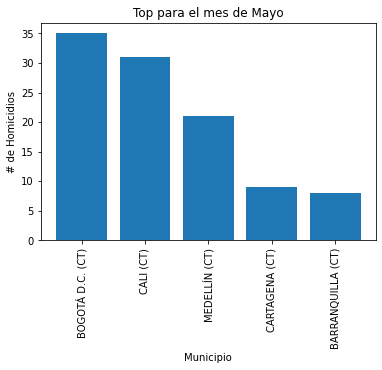

¿Desea Visualizar otro mes?(Si/No): No


In [ ]:
# Grafica
Next = True
meses=['01','02','03','04','05','06','07','08','09','10','11','12']
meses_names=['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
while Next == True :
  incorrecto_mes= True
  intentos_mes=0
  while incorrecto_mes and intentos_mes<3:
    mes_in=input("Ingrese el mes que desea visualizar (01,02,...,12):\n ")
    if (mes_in not in meses):
      print('El valor ingresado no es correcto, intente nuevamente: ')
      intentos_mes+=1
    else:
      incorrecto_mes= False
      info_mes= Count_muni.loc[mes_in]
  incorrecto_top = True 
  intentos_top=0
  while (not incorrecto_mes) and incorrecto_top and intentos_top<3 :
    top_in= int(input('¿Cuantos valores desea visualizar en el top?:\n '))
    if top_in >= len(info_mes):
      print('El valor ingresado es mayor al número de municipios con homicidios, intentelo nuevamente')
      intentos_top+=1
    else:
      incorrecto_top = False
  if ((not incorrecto_mes) and (not incorrecto_top)):
    chart_b=plt.bar(info_mes['Municipio'][:top_in],info_mes[0][:top_in])
    plt.xticks(rotation=90)
    plt.title('Top para el mes de '+meses_names[int(mes_in)-1])
    plt.xlabel('Municipio')
    plt.ylabel('# de Homicidios')
    plt.show()
  otro= input('¿Desea Visualizar otro mes?(Si/No): ')
  if otro=='Si':
    Next=True
  else:
    Next=False

### For Bogota, what neighborhoods reported greater amount of murders between 6 at night and 12 midnight.

In [ ]:
query = """
SELECT   Barrio
        , Count(*) AS Total
FROM `seleccion-analyticlab.HomicidiosColombia.Homicidios_2018`
WHERE Municipio = 'BOGOTÁ D.C. (CT)' AND (Hora Between '18:00:00' AND '24:00:00' ) AND Cantidad <> 12667
GROUP BY Barrio
"""
query_job = client.query(query)
results_top_barrios = query_job.result().to_dataframe()
results_top_barrios=results_top_barrios.sort_values('Total', ascending= False)

¿Cuantos barrios desea visualizar en el top?:
 5


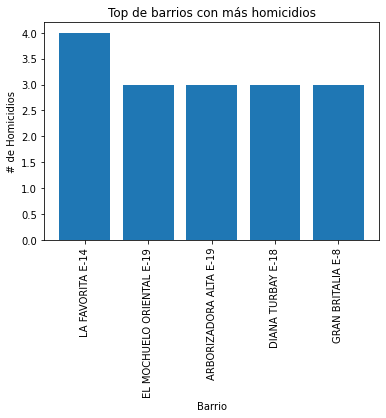

In [ ]:
# Grafica
Next = True
incorrecto_top = True 
intentos_top=0
while incorrecto_top and intentos_top<3 :
  top_in= int(input('¿Cuantos barrios desea visualizar en el top?:\n '))
  if top_in >= len(results_top_barrios):
    print('El valor ingresado es mayor al número de barrios con homicidios, intentelo nuevamente')
    intentos_top+=1
  else:
    incorrecto_top = False
if (not incorrecto_top):
  chart_b=plt.bar(results_top_barrios['Barrio'][:top_in],results_top_barrios['Total'][:top_in])
  plt.xticks(rotation=90)
  plt.title('Top de barrios con más homicidios')
  plt.xlabel('Barrio')
  plt.ylabel('# de Homicidios')
  plt.show()

### What other insights can you extract from this dataset

Algunos ejemplos de la información que se puede extraer de este dataset son:
- Las horas con mayor número de Homicidios.
- Las armás más comunes empleadas para Homicidios. 
- Las zonas más seguras de cada ciudad en terminos de homicidios. 
- Las capitales com mayor o menos número de homicidios. 

## Machine Learning

### Would make sense a machine learning model for supporting the police force in its work?  What kind of model would you choose (regression, classification, clustering)?

Si, tendría sentido ya que la información proporcionada por un modelo de machine learning puede ser utilizada para predecir las zonas más vulnerables y la cantidad de casos que se deben tratar en cierto día. Esta información puede ser de gran utilidad para optimizar la operación de la policia. 
En este caso utilizaria una regresión para predecir el número de homicidios que sucederan en los proximos diás. 

In [ ]:
query = """
SELECT  Fecha
        ,Dia
FROM `seleccion-analyticlab.HomicidiosColombia.Homicidios_2018`
WHERE Cantidad <> 12667
"""
query_job = client.query(query)
results_dia_pais = query_job.result().to_dataframe()

In [ ]:
#Se corrige el formato de fecha 
results_dia_pais['Fecha']=pd.to_datetime(results_dia_pais['Fecha'].str.slice(0,10))
# Se calcula el total de asesinatos por dia
count_dia_pais= results_dia_pais.pivot_table(index=['Fecha','Dia'],aggfunc='size')
count_dia_pais= count_dia_pais.reset_index(level=[0,1])
count_dia_pais= count_dia_pais.sort_values('Fecha')
#Se cambia la columna de fecha
count_dia_pais['Fecha']= (count_dia_pais['Fecha']-count_dia_pais['Fecha'][0]).dt.days

In [ ]:
# Se calculan los dummies
df_dia_pais= pd.get_dummies(count_dia_pais)
df_dia_pais=df_dia_pais.rename(columns={0:'Total'})
y= df_dia_pais['Total']
x= df_dia_pais.drop(columns='Total')

Se divide en datos de entrenamiento y prueba. A pesar de que usualmente esto se hace aleatoriamente, es necesario tener en cuenta que se esta trabajando con una serie de tiempo

In [ ]:
#Se divide en datos de entrenamiento y prueba
n_train=int(np.ceil(len(y)*0.70))
X_train= x.iloc[:n_train]
X_test= x.iloc[n_train:]
Y_train= y.iloc[:n_train]
Y_test= y.iloc[n_train:]

In [ ]:
#Modelo
model= LinearRegression()

# fit linear regression
m.fit(X_train, Y_train)

In [ ]:
#Modelo
model= LinearRegression()
model.fit(X_train, Y_train)
print(model.intercept_)
print(model.coef_)
# [ 5.97694123 19.37771052]

35.09736071056576
[-4.11911156e-03  1.76364541e+01 -4.62833121e+00  2.38060852e-01
 -7.40084472e+00 -4.92637462e+00  5.58503261e+00 -6.50399698e+00]


En el proceso de selección, se realizaron pruebas con otros metodos como random forest. El mejor resultado se encontró con la regresión lineal que se evalúa a continuación. 

In [ ]:
model.score(X_test,Y_test)

0.6327655195678854

###How would you deploy your model?
Integraría el modelo con la plataforma que maneje la policia para la asignación de turnos( En el caso en el que se cuente con una), con el fin de optimizar la cantidad de policias en relación a los posibles homicidios que se puedan presentar ese día. Como trabajo futuro se podría mejorar el modelo para tener en cuenta otros tipo de crimenes, los barrios y la cercania entre estos para hacer planeación de ruta de las patrullas. 